# Title

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torchvision.transforms as tfs
from dataset import SOCOFingDataset
from matplotlib import colors, pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from utils import seed

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed(42)

In [3]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu")
DEVICE

device(type='cuda', index=0)

## Data prepare

In [4]:
files = sorted(
    list(Path("../SOCOFing/Real").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Easy").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Medium").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Hard").rglob("*.BMP"))
)

In [5]:
labels = [file.name[0 : file.name.find("_")] for file in files]
train_files, test_files = train_test_split(files, test_size=0.4, stratify=labels)

test_labels = [file.name[0 : file.name.find("_")] for file in test_files]
test_files, val_files = train_test_split(
    test_files, test_size=0.5, stratify=test_labels
)

len(train_files), len(test_files), len(val_files)

(33162, 11054, 11054)

In [6]:
train_dataset = SOCOFingDataset(files, (64, 64), "train")
test_dataset = SOCOFingDataset(files, (64, 64), "test")
val_dataset = SOCOFingDataset(files, (64, 64), "val")

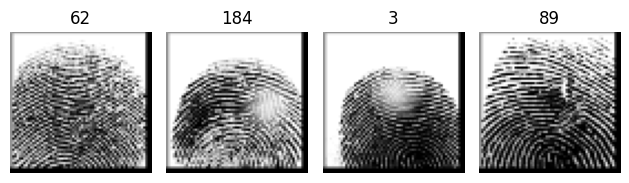

In [7]:
def imshow(dataset, indicies):
    fig, axeslist = plt.subplots(ncols=len(indicies), nrows=1)
    for i in range(len(indicies)):
        image, label = dataset[indicies[i]]
        image = image.numpy().transpose((1, 2, 0))
        axeslist.ravel()[i].imshow(image, cmap=plt.gray())
        axeslist.ravel()[i].set_title(label)
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout()


imshow(train_dataset, np.random.randint(0, 6000, 4))

## Model

In [71]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 600)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [72]:
model = NN(64 * 64).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

## Train

In [73]:
batch_size = 100

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [84]:
%%time

best_model = model

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_acc = 0.0

for epoch in range(100):
    # Train stage
    model.train()

    train_loss = 0.0
    train_acc = 0.0
    n_samples = 0.0

    for X, y in train_loader:
        # Setup
        X = X.view(-1, 64 * 64).to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        # Train
        y_pred = model(X)
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        # Evaluate
        train_acc += torch.sum(y.data == torch.argmax(y_pred, 1))
        n_samples += X.size(0)

    # Log
    train_acc /= n_samples
    train_loss_history.append(train_loss.cpu().data)
    train_acc_history.append(train_acc.cpu().data)

    # Eval stage
    model.eval()

    val_loss = 0.0
    val_acc = 0.0
    n_samples = 0.0

    for X, y in val_loader:
        X = X.view(-1, 64 * 64).to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            y_pred = model(X)
            val_loss = criterion(y_pred, y)
            val_acc += torch.sum(y.data == torch.argmax(y_pred, 1))
            n_samples += X.size(0)

    # Log
    val_acc /= n_samples
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Save if improved
    if train_acc > best_acc:
        best_acc = train_acc
        best_model = model

    print(
        f"Epoch {epoch}, "
        f"train_loss: {train_loss}, "
        f"val_loss: {val_loss}, "
        f"train_acc {train_acc:0.4f}, "
        f"val_acc: {val_acc}"
    )

print("Best accuracy:", best_acc)

Epoch 0, train_loss: 0.08378032594919205, val_loss: 0.15382276475429535, train_acc 0.9853, val_acc: 0.9501538276672363


KeyboardInterrupt: 

In [111]:
y = model(img.view(-1, 64 * 64).to(DEVICE))

In [112]:
torch.argmax(y, 1)

tensor([32], device='cuda:0')

In [113]:
# plt.plot()

## Save model

In [77]:
torch.save(model, Path("../models/nn_sm_acc_99"))